University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  

# Week 2 exercises

## 1. Permutation testing (6 pts)

We will use permutation testing to study if the mother's age (`age`) affects the birth weight (`bwt`) of their babies. We will use the absolute difference in the means as the test statistic. We will focus the analysis on full term pregnancies (`gestation >= 273`).

*Note*: When reporting a $p$-value for $b$ more extreme tests out of $m$, use $p = (b+1)/(m+1)$ to avoid zero p-values. 50000 permutations will be sufficient for obtaining the required accuracy.

1. Load the data set below. Test whether the birth weights (`bwt`) of babies with young (`age < 26`) and older (`age >= 26`) mothers are statistically significantly different using the difference of the means as the test statistic. Report the $p$-value you obtain in Moodle.
2. Stratify the analysis by the variable smoking status of the mothers by splitting to separate smoker (`smoke = 0`) and non-smoker (`smoke = 1`) groups. Constrain the permutations so that only changes within each group are allowed. After the permutation, merge the two groups back together to compute the means. Report the $p$-value you obtain in Moodle.

In [31]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

def shuffle(x1, x2):
    """Return a random reshuffling of elements in two arrays""" 
    n1 = len(x1)
    z = npr.permutation(np.concatenate((x1, x2)))
    return z[0:n1], z[n1:]

# Load the data set
babies_full = pd.read_csv("https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/babies2.txt", sep='\t')

# Pick a subset
babies = babies_full[babies_full['gestation']>=273]
bwt_1 = babies[(babies['age']<26)]['bwt']
bwt_2 = babies[(babies['age']>=26)]['bwt']

N = 50000

truediff = np.abs(np.mean(bwt_1) - np.mean(bwt_2))
# Repeatedly randomly permute to mix the groups
meandiffs = [] 
for i in range(N):
    new_bwt1, new_bwt2 = shuffle(bwt_1,bwt_2)

    meandiffs.append(np.abs(np.mean(new_bwt1) - np.mean(new_bwt2)))

print(f'p-value: {(np.sum(truediff <= meandiffs)+1)/(len(meandiffs)+1)}')


p-value: 0.0750184996300074


## 2. Bootstrap confidence intervals on data statistics (4 pts)

In this exercise we use bootstrap to estimate confidence intervals for various quantities. (Using 1000 bootstrap samples will give you enough accuracy assuming everything is correctly done.)

1. Use bootstrap to estimate the central 95% confidence interval for the mean of `bwt` in the *full* data set loaded in Problem 1. Report the lower and upper ends of the interval in Moodle.
2. Use bootstrap to estimate the central 95% confidence interval for the mean of `bwt` in the smaller subset (`gestation >= 273`) of the data set used in Problem 1. Report the lower and upper ends of the interval in Moodle.
3. Use bootstrap to estimate the central 95% confidence interval for the correlation coefficient of `gestation` and `age` in the full data set loaded in Problem 1. What does this tell about the relation between the duration of the pregnancy and the age of the mother? Report the bounds of the interval in Moodle.
4. Use bootstrap to estimate the central 95% confidence interval for the correlation coefficient of `gestation` and `age` in the smaller subset (`gestation >= 273`) used in Problem 1. What does this tell about the relation between the duration of the pregnancy and the age of the mother? Report the bounds of the interval in Moodle.

*Hint*: Remember that the size of the bootstrap sample is always the same as the size of the original data set.

In [35]:
N = 1000

bwt = babies_full['bwt']
n = len(bwt)
means = [np.mean(npr.choice(bwt, size=n, replace=True)) for _ in range(N)]
print(f'(1) The 5% confidence interval of means are: {np.percentile(means, [2.5, 97.5])}')

subset_babies = babies_full.iloc[(babies_full['gestation']>=273).values]
bwt = subset_babies['bwt']
n = len(bwt)
means = [np.mean(npr.choice(bwt, size=n, replace=True)) for _ in range(N)]
print(f'(2) The 5% confidence interval of subset means are: {np.percentile(means, [2.5, 97.5])}')

corrcoefs = np.empty(N)
for i in range(N):
    resampled = babies_full.sample(n=len(babies_full), replace=True)
    corrcoefs[i] = np.corrcoef(resampled['gestation'], resampled['age'])[0, 1]
print(f'(3) The 5% confidence interval of corrcoefs between gestation and age in full dataset are: {np.percentile(corrcoefs, [2.5, 97.5])}')

corrcoefs = np.empty(N)
for i in range(N):
    resampled = subset_babies.sample(n=len(subset_babies), replace=True)
    corrcoefs[i] = np.corrcoef(resampled['gestation'], resampled['age'])[0, 1]

print(f'(4) The 5% confidence interval of corrcoefs between gestation and age in subset are: {np.percentile(corrcoefs, [2.5, 97.5])}')


(1) The 5% confidence interval of means are: [118.49744246 120.48740409]
(2) The 5% confidence interval of subset means are: [122.48494253 124.6187931 ]
(3) The 5% confidence interval of corrcoefs between gestation and age in full dataset are: [-1.10145919e-01  6.43379216e-05]
(4) The 5% confidence interval of corrcoefs between gestation and age in subset are: [-0.09508087  0.03513651]


## 3. Bootstrap confidence intervals on parameter estimates (4 pts)

In this task, we will use bootstrap to obtain confidence intervals on maximum likelihood parameter estimates for linear regression models. We will apply simple case resampling, i.e. resampling the individuals and then fitting the model using the data $(x_i, y_i)$ from these individuals. There are alternative methods that may work better when the data are limited, but in our case there are enough observations so that this will not be a problem. 1000 bootstrap samples will again give you enough accuracy.

A linear regression fit to scalar $x_i, y_i$ involves fitting the model
$$ y_i = \alpha + \beta x_i + \epsilon_i, $$
where $\beta$ is the regression coefficient and $\alpha$ is the intercept. Assuming $\epsilon_i \sim N(0, \sigma^2)$, the log-likelihood of the model is
$$ \log p(Y | X, \alpha, \beta) = \sum_{i=1}^n \log p(y_i | x_i, \alpha, \beta)
  = \sum_{i=1}^n - \frac{1}{2 \sigma^2} (y_i - \alpha - \beta x_i)^2 + C, $$
where $C$ is independent of $\alpha, \beta$. This is maximised when
$$ \hat{\beta}= \frac{\sum_{i = 1}^n (x_i - \bar{x})(y_i - \bar{y}) }{ \sum_{i = 1}^n (x_i - \bar{x})^2} \\
   \hat{\alpha} = \bar{y} - \hat{\beta} \bar{x},$$
where $\bar{x} = \frac{1}{n} \sum_{i = 1}^n x_i$ and $\bar{y} = \frac{1}{n} \sum_{i = 1}^n y_i$.

1. Implement the above linear regression model to predict `gestation` ($y$) as a function of `age` ($x$) in the full data set. Report the estimated $\beta$ in Moodle.
2. Use bootstrap to estimate the confidence interval of the regression coefficient $\beta$ in the above model by resampling the individuals used to fit the model. Report the lower and upper bounds of the central 95% confidence interval of $\beta$ in Moodle.


In [ ]:
import pandas as pd
import numpy as np
import numpy.random as npr

# Load the data set
babies_full = pd.read_csv("https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/babies2.txt", sep='\t')

babies3 = babies_full

## 4. Density estimation (6 pts)

1. Estimate the joint density of `bwt` and `age` in the full data set using kernel density estimation with a 2-dimensional Gaussian kernel
$$ K(\mathbf{x}) = \frac{1}{2\pi} \exp\left( - \frac{\|\mathbf{x}\|^2}{2} \right)
 = \frac{1}{2\pi} \exp\left( - \frac{x_1^2 + x_2^2}{2} \right) $$
using bandwidth $h=5$. Report the value of the estimated density at point `bwt=110`, `age=31` in Moodle.

*Hint*: you can verify your results by ploting a 2D histogram of the data (`matplotlib.pyplot.hist2d`) and a contour plot of the estimated density (see e.g. Sec. 5.1.1 in Course notes for a contour plot example).

2. With the Gaussian kernel above, use leave-one-out (LOO) cross validation to find the optimal $h$ in the range `np.linspace(1.0, 5.0, 50)`. The optimal $h$ maximizes the LOO log-likelihood. Report the value of $h$ and the value of the estimated density at `bwt=110`, `age=31` in Moodle.

3. Use $k$-fold cross validation with $k=17$ to find the optimal $h$ in the range `np.linspace(1.0, 5.0, 50)`. Report the value of $h$ and the value of the estimated density at `bwt=110`, `age=31` in Moodle. For this exercise, the sample point indices for the $k$ partitions of the data should consist of consecutive indices, e.g. the first partition should be the data with indices `0:69` and so on. (In practical applications it is generally good practice to randomly permute the indices as well when creating partitions, but don't do it for this exercise.)

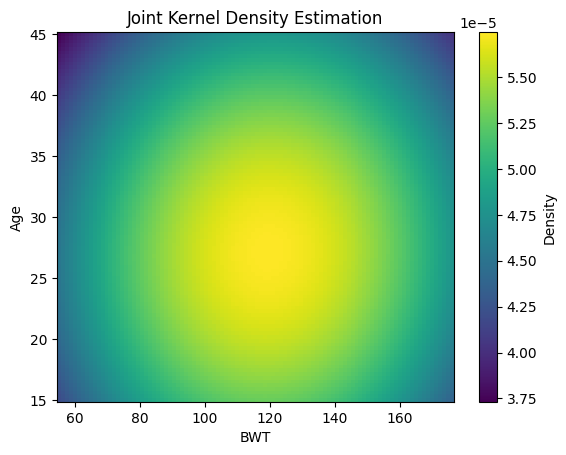

In [36]:
import pandas as pd
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
bwt = babies_full['bwt'].values
age = babies_full['age'].values

# Create a 2D array with bwt and age
data_array = np.vstack([bwt, age])

# Create the KDE object with a bandwidth of 5
kde = gaussian_kde(data_array, bw_method=5)

def kernel_density(t, x, h):
    """Return kernel density at t estimated for points x with width h Input: t (np.array, shape (k, )) for k points or float for 1 point x (np.array, shape (n, )) for n points
    h double"""
    try:
        N =  len(t)
    except: # t is a scalar value if it has no length
        t = np.array([t])
        N=1
    y = np.zeros(N)
    for i in range(N):
        y[i] = np.mean(K_gauss((t[i] - x)/ h)) / h

    return y

t = np.linspace(-2, 10, 100)
plt.plot(t, kernel_density(t, d, 3.0), label='h=3.0')
